In [1]:
!git clone https://github.com/2runo/Curse-detection-data

Cloning into 'Curse-detection-data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [2]:
pip install soynlp

     |████████████████████████████████| 419kB 13.0MB/s 


In [133]:
import csv
import pandas as pd
contents = []

with open('Curse-detection-data/dataset.txt', 'r',encoding='UTF8') as f:
    reader = csv.reader(f, delimiter = '\t')
    for row in f:
        contents.append(row.split('|'))
        
df = pd.DataFrame(contents, columns=['document','label','none'])


In [134]:
df[df['label'].apply(lambda x: '한경' in x)]
df.drop(455, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df['label'] = df['label'].apply(lambda x : int(x.replace("\n","")))
df.drop('none',axis=1,inplace=True)

In [9]:
 cd ../content/drive/MyDrive/4-1 데분캡/Mecab-ko-for-Google-Colab

/content/drive/MyDrive/4-1 데분캡/Mecab-ko-for-Google-Colab


In [10]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 460kB 46.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-05-28 14:24:50--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c3:9b0a, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=EUM4UvuyYs79EBcWu3THhsBSrtw%3D&Expires=1622212940&AWSAccessKeyId=AKIA6KOSE3BNJ

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [136]:
from soynlp.normalizer import *

df['document'] = df['document'].apply(emoticon_normalize)

In [137]:
drop_list = df[df.document.apply(lambda x:'http' in x)].index
df.drop(drop_list,inplace=True)
df.reset_index(drop=True, inplace=True)
y=df['label']
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42, stratify = y)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))
train_data.label.value_counts(), test_data.label.value_counts(), 

훈련용 리뷰의 개수 : 4352
테스트용 리뷰의 개수 : 1451


(0    2821
 1    1531
 Name: label, dtype: int64, 0    941
 1    510
 Name: label, dtype: int64)

In [138]:
test_data.label.value_counts()

0    941
1    510
Name: label, dtype: int64

In [139]:
train_data.label.value_counts()

0    2821
1    1531
Name: label, dtype: int64

In [140]:
import random
import pickle
import re

wordnet = {}
with open("/content/drive/MyDrive/4-1 데분캡/wordnet.pickle", "rb") as f:
	wordnet = pickle.load(f)


# 한글만 남기고 나머지는 삭제
def get_only_hangul(line):
	parseText= re.compile('/ ^[ㄱ-ㅎㅏ-ㅣ가-힣]*$/').sub('',line)

	return parseText



########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################
def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			num_replaced += 1
		if num_replaced >= n:
			break

	if len(new_words) != 0:
		sentence = ' '.join(new_words)
		new_words = sentence.split(" ")

	else:
		new_words = ""

	return new_words


def get_synonyms(word):
	synomyms = []

	try:
		for syn in wordnet[word]:
			for s in syn:
				synomyms.append(s)
	except:
		pass

	return synomyms

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################
def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	
	return new_words


def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		if len(new_words) >= 1:
			random_word = new_words[random.randint(0, len(new_words)-1)]
			synonyms = get_synonyms(random_word)
			counter += 1
		else:
			random_word = ""

		if counter >= 10:
			return
		
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)



def EDA(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	sentence = get_only_hangul(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not ""]
	num_words = len(words)

	augmented_sentences = []
	num_new_per_technique = int(num_aug/4) + 1

	n_sr = max(1, int(alpha_sr*num_words))
	n_ri = max(1, int(alpha_ri*num_words))
	n_rs = max(1, int(alpha_rs*num_words))

	# sr
	for _ in range(num_new_per_technique):
		a_words = synonym_replacement(words, n_sr)
		augmented_sentences.append(' '.join(a_words))

	# # ri
	# for _ in range(num_new_per_technique):
	# 	a_words = random_insertion(words, n_ri)
	# 	augmented_sentences.append(' '.join(a_words))

	# # rs
	# for _ in range(num_new_per_technique):
	# 	a_words = random_swap(words, n_rs)
	# 	augmented_sentences.append(" ".join(a_words))

	# # rd
	# for _ in range(num_new_per_technique):
	# 	a_words = random_deletion(words, p_rd)
	# 	augmented_sentences.append(" ".join(a_words))

	# augmented_sentences = [get_only_hangul(sentence) for sentence in augmented_sentences]
	# random.shuffle(augmented_sentences)

	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	augmented_sentences.append(sentence)

	return augmented_sentences

In [141]:
train_data.reset_index(drop=True,inplace=True)

In [142]:
# eda를 한 후, 저장
new_train_set = []
for i in train_data.index:
    new_sentence = EDA(train_data.loc[i,'document'])
    for new in new_sentence:
        new_train_set.append((new,df.loc[i,'label']))
new_train_set

[('개쫄리나보ㅋㅋㅋ 잘가라^^', 1),
 ('개쫄리나보ㅋㅋㅋ 잘가라^^', 1),
 ('개쫄리나보ㅋㅋㅋ 잘가라^^', 1),
 ('개쫄리나보ㅋㅋㅋ 잘가라^^', 1),
 ('니네집은 얼만데?', 0),
 ('니네집은 얼만데?', 0),
 ('니네집은 얼만데?', 0),
 ('니네집은 얼만데?', 0),
 ('땅콩 사무장양반 중간에 낑기게 한게 더얄미움', 1),
 ('땅콩 사무장양반 중간에 낑기게 한게 더얄미움', 1),
 ('땅콩 사무장양반 중간에 낑기게 한게 더얄미움', 1),
 ('땅콩 사무장양반 중간에 낑기게 한게 더얄미움', 1),
 ('충선왕이 소를 좋아했어!', 0),
 ('충선왕이 소를 좋아했어!', 0),
 ('충선왕이 소를 좋아했어!', 0),
 ('충선왕이 소를 좋아했어!', 0),
 ('한달쯤 전에 돈이 필요해서 천주 팔았는데 그때 54,600인가 그랬는데 5백 손해본거같아 억울하다이기', 1),
 ('한달쯤 전에 돈이 필요해서 천주 팔았는데 그때 54,600인가 그랬는데 5백 손해본거같아 억울하다이기', 1),
 ('한달쯤 전에 돈이 필요해서 천주 팔았는데 그때 54,600인가 그랬는데 5백 손해본거같아 억울하다이기', 1),
 ('한달쯤 전에 돈이 필요해서 천주 팔았는데 그때 54,600인가 그랬는데 5백 손해본거같아 억울하다이기', 1),
 ('터부시 = 금기시', 1),
 ('터부시 = 금기시', 1),
 ('터부시 = 금기시', 1),
 ('터부시 = 금기시', 1),
 ('헤비구스다운 미만잡입니다 여러분', 1),
 ('헤비구스다운 미만잡입니다 여러분', 1),
 ('헤비구스다운 미만잡입니다 여러분', 1),
 ('헤비구스다운 미만잡입니다 여러분', 1),
 ('아이폰11 s11 겹쳐서 비교 ㅈㄴ 당하니까 삼성이 출시연도에 맞게 바꿈 2020=s20 2021=s21', 1),
 ('아이폰11 s11 겹쳐서 비교 ㅈㄴ 당하니까 삼성이 출시연도에 맞게 바꿈 2020=s20 2021=s21', 1),
 ('아이폰11 s11 겹쳐서

In [143]:
new_df = pd.DataFrame(new_train_set, columns=['document','label'])
train_concat = pd.concat([train_data, new_df], axis=0)
train_concat = train_concat.drop_duplicates() #중복 삭제

In [144]:
train_concat.label.value_counts()

0    5091
1    3253
Name: label, dtype: int64

In [146]:
train_data = train_concat
train_data.label.value_counts()

0    5091
1    3253
Name: label, dtype: int64

In [147]:
mecab=Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']
train_data['tokenized'] = train_data['document'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['document'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [148]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

단어 집합(vocabulary)의 크기 : 10229
등장 빈도가 1번 이하인 희귀 단어의 수: 1979
단어 집합에서 희귀 단어의 비율: 19.346954736533387
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4330091744447904
단어 집합의 크기 : 8252


In [149]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 100
below_threshold_len(max_len, X_train)
X_train = pad_sequences(X_train, maxlen = max_len,  padding='post')
X_test = pad_sequences(X_test, maxlen = max_len , padding='post' )

전체 샘플 중 길이가 100 이하인 샘플의 비율: 98.52588686481305


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [151]:
import gensim
loaded_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/4-1 데분캡/aihub_review_6.model") # 모델 로드

In [152]:
import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 100차원 vector를 가져옵니다
for word, idx in tokenizer.word_index.items():
    embedding_vector = loaded_model[word] if word in loaded_model else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
embedding_matrix.shape
# (10436, 100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


(10231, 100)

In [153]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

def plt_show():
        # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

test_result=[]

def DNN():
    global history
    # 모델 구조 정의하기
    model = models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(layers.Dense(64, activation= 'relu')) 
    model.add(BatchNormalization())
    model.add(layers.Dense(64, activation= 'relu')) #ReLU 활성화함수 채택
    model.add(BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('DNN',score))
    plt_show()


def lstm():
    global history
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(BatchNormalization())
    model.add(LSTM(128))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('LSTM',score))
    plt_show()

def lstm_2_layer():
    global history
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))

    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('LSTM_2layer',score))
    plt_show()

def bidirectional_lstm():
    global history
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('Bi-LSTM',score))
    plt_show()

def bidirectional_lstm_2():
    global history
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('Bi-LSTM-2',score))
    plt_show()

from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

def cnn_1D():
    global history
    model = Sequential()    
    model.add(Embedding(VOCAB_SIZE, 
                    EMBEDDING_DIM, 
                    input_length=max_len, 
                    weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                    trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                   )
         )
    model.add(BatchNormalization())
    model.add(Conv1D(256, 3, padding='valid', activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    score = model.evaluate(X_test, y_test)[1]
    print("테스트 정확도: %.4f" % (score))
    test_result.append(('1D-CNN',score))
    plt_show()

def bi_attention():
    global history
    sequence_input = Input(shape=(max_len,), dtype='int32')

    embedded_sequences = Embedding(VOCAB_SIZE, 
                        EMBEDDING_DIM, 
                        input_length=max_len, 
                        weights=[embedding_matrix], # weight는 바로 위의 embedding_matrix 대입
                        trainable=False # embedding layer에 대한 train은 꼭 false로 지정
                       )(sequence_input)

    # embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)
    lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)
    lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

    state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
    state_c = Concatenate()([forward_c, backward_c]) # 셀 상태
    attention = BahdanauAttention(64) # 가중치 크기 정의
    context_vector, attention_weights = attention(lstm, state_h)

    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.5)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model = Model(inputs=sequence_input, outputs=output)
    filename = 'best_model.h5'
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                                monitor='val_accuracy',   # val_loss 값이 개선되었을때 호출됩니다
                                verbose=1,            # 로그를 출력합니다
                                save_weights_only = True,
                                save_best_only = True,  # 가장 best 값만 저장합니다
                                # 가장 best 값만 저장합니다
                                mode='max',           # auto는 알아서 best를 찾습니다. min/max

                                )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = 100, callbacks= [checkpoint], batch_size = 256, validation_data=(X_test, y_test), verbose=1)
    model.load_weights(filename)
    test_result.append(('Bi-lstm+Attention', model.evaluate(X_test, y_test)[1] ))
    plt_show()

# EDA_AUG 결과


DNN 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 1s 15ms/step - loss: 0.7284 - accuracy: 0.5932 - val_loss: 0.6554 - val_accuracy: 0.6485

Epoch 00001: val_accuracy improved from -inf to 0.64855, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.6789 - accuracy: 0.6043 - val_loss: 0.6487 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.64855
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6731 - accuracy: 0.6073 - val_loss: 0.6471 - val_accuracy: 0.6485

Epoch 00003: val_accuracy did not improve from 0.64855
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.6709 - accuracy: 0.6082 - val_loss: 0.6488 - val_accuracy: 0.6485

Epoch 00004: val_accuracy did not improve from 0.64855
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6698 - accuracy: 0.6092 - val_loss: 0.6491 - val_accuracy: 0.6485

Epoch 00005: val_accur

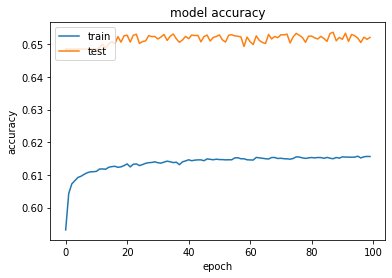

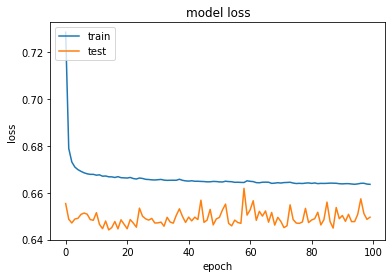


LSTM 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 3s 27ms/step - loss: 0.7231 - accuracy: 0.5864 - val_loss: 0.6576 - val_accuracy: 0.6485

Epoch 00001: val_accuracy improved from -inf to 0.64852, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 1s 15ms/step - loss: 0.6857 - accuracy: 0.6136 - val_loss: 0.6558 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.64852
Epoch 3/100
33/33 [==============================] - 0s 15ms/step - loss: 0.6804 - accuracy: 0.6141 - val_loss: 0.6524 - val_accuracy: 0.6492

Epoch 00003: val_accuracy improved from 0.64852 to 0.64921, saving model to best_model.h5
Epoch 4/100
33/33 [==============================] - 1s 15ms/step - loss: 0.6747 - accuracy: 0.6141 - val_loss: 0.6569 - val_accuracy: 0.6478

Epoch 00004: val_accuracy did not improve from 0.64921
Epoch 5/100
33/33 [==============================] - 0s 15ms/step - loss: 0.6724 - accuracy: 0.6153 - val_loss: 0.6557 - val_

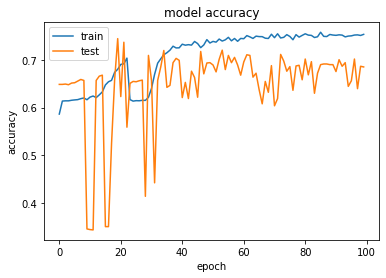

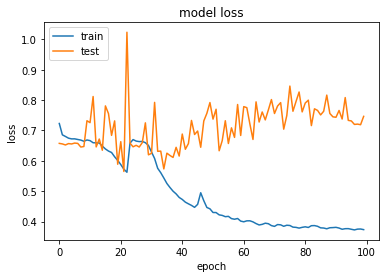


LSTM_2layer 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 4s 45ms/step - loss: 0.6725 - accuracy: 0.6116 - val_loss: 0.6460 - val_accuracy: 0.6533

Epoch 00001: val_accuracy improved from -inf to 0.65334, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6671 - accuracy: 0.6136 - val_loss: 0.6555 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.65334
Epoch 3/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6663 - accuracy: 0.6151 - val_loss: 0.6514 - val_accuracy: 0.6547

Epoch 00003: val_accuracy improved from 0.65334 to 0.65472, saving model to best_model.h5
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6636 - accuracy: 0.6160 - val_loss: 0.6460 - val_accuracy: 0.6582

Epoch 00004: val_accuracy improved from 0.65472 to 0.65817, saving model to best_model.h5
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6663 - 

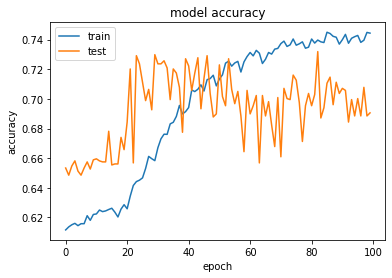

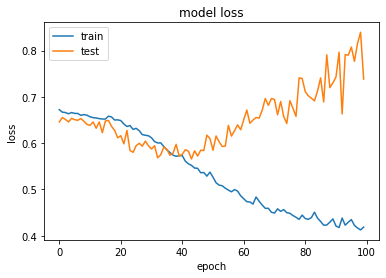


Bi-LSTM 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 5s 48ms/step - loss: 0.7412 - accuracy: 0.5543 - val_loss: 0.6407 - val_accuracy: 0.6485

Epoch 00001: val_accuracy improved from -inf to 0.64852, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 0.6226 - accuracy: 0.6607 - val_loss: 0.6263 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.64852
Epoch 3/100
33/33 [==============================] - 1s 28ms/step - loss: 0.5930 - accuracy: 0.6764 - val_loss: 0.6146 - val_accuracy: 0.6485

Epoch 00003: val_accuracy did not improve from 0.64852
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 0.5632 - accuracy: 0.6989 - val_loss: 0.6105 - val_accuracy: 0.6499

Epoch 00004: val_accuracy improved from 0.64852 to 0.64990, saving model to best_model.h5
Epoch 5/100
33/33 [==============================] - 1s 29ms/step - loss: 0.5402 - accuracy: 0.7047 - val_loss: 0.6135 - v

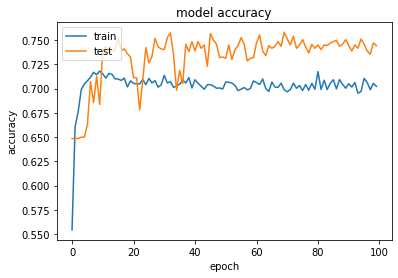

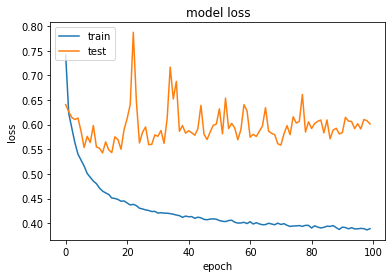


Bi-LSTM 2층 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 8s 96ms/step - loss: 0.7859 - accuracy: 0.5453 - val_loss: 0.6432 - val_accuracy: 0.6485

Epoch 00001: val_accuracy improved from -inf to 0.64852, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 2s 61ms/step - loss: 0.6141 - accuracy: 0.6661 - val_loss: 0.6352 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.64852
Epoch 3/100
33/33 [==============================] - 2s 60ms/step - loss: 0.5719 - accuracy: 0.6855 - val_loss: 0.6279 - val_accuracy: 0.6485

Epoch 00003: val_accuracy did not improve from 0.64852
Epoch 4/100
33/33 [==============================] - 2s 61ms/step - loss: 0.5397 - accuracy: 0.6949 - val_loss: 0.6157 - val_accuracy: 0.6492

Epoch 00004: val_accuracy improved from 0.64852 to 0.64921, saving model to best_model.h5
Epoch 5/100
33/33 [==============================] - 2s 61ms/step - loss: 0.5171 - accuracy: 0.7034 - val_loss: 0.5965 

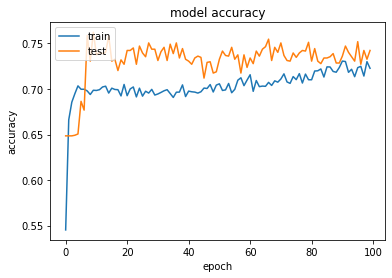

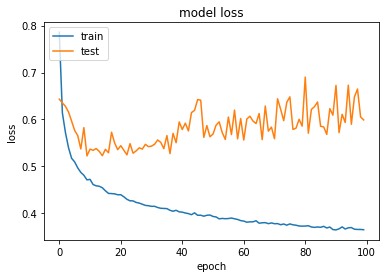

D-CNN 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 2s 20ms/step - loss: 0.8198 - accuracy: 0.5313 - val_loss: 0.6362 - val_accuracy: 0.6485

Epoch 00001: val_accuracy improved from -inf to 0.64852, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6886 - accuracy: 0.6186 - val_loss: 0.6358 - val_accuracy: 0.6485

Epoch 00002: val_accuracy did not improve from 0.64852
Epoch 3/100
33/33 [==============================] - 0s 15ms/step - loss: 0.6329 - accuracy: 0.6523 - val_loss: 0.6397 - val_accuracy: 0.6485

Epoch 00003: val_accuracy did not improve from 0.64852
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5967 - accuracy: 0.6841 - val_loss: 0.6560 - val_accuracy: 0.6485

Epoch 00004: val_accuracy did not improve from 0.64852
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5803 - accuracy: 0.6920 - val_loss: 0.6312 - val_accuracy: 0.6485

Epoch 00005: val

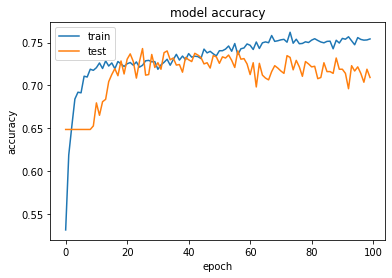

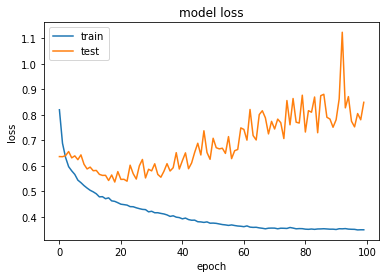

\Bi-LSTM+Attention 모델 진행합니다.
Epoch 1/100
33/33 [==============================] - 8s 84ms/step - loss: 0.6732 - accuracy: 0.6073 - val_loss: 0.6329 - val_accuracy: 0.6520

Epoch 00001: val_accuracy improved from -inf to 0.65196, saving model to best_model.h5
Epoch 2/100
33/33 [==============================] - 2s 47ms/step - loss: 0.6646 - accuracy: 0.6092 - val_loss: 0.5981 - val_accuracy: 0.6961

Epoch 00002: val_accuracy improved from 0.65196 to 0.69607, saving model to best_model.h5
Epoch 3/100
33/33 [==============================] - 2s 46ms/step - loss: 0.6597 - accuracy: 0.6139 - val_loss: 0.5882 - val_accuracy: 0.6644

Epoch 00003: val_accuracy did not improve from 0.69607
Epoch 4/100
33/33 [==============================] - 2s 47ms/step - loss: 0.6569 - accuracy: 0.6137 - val_loss: 0.5643 - val_accuracy: 0.6782

Epoch 00004: val_accuracy did not improve from 0.69607
Epoch 5/100
33/33 [==============================] - 2s 47ms/step - loss: 0.6558 - accuracy: 0.6146 - val_loss: 

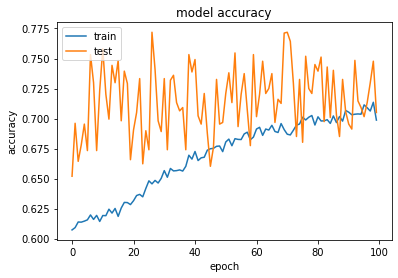

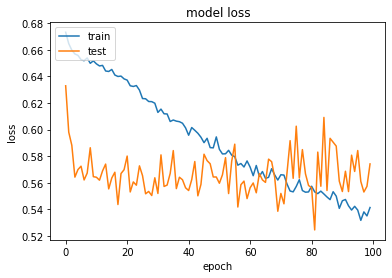

In [154]:
test_result = []    
print("\nDNN 모델 진행합니다.")
DNN()
print("\nLSTM 모델 진행합니다.")
lstm()
print("\nLSTM_2layer 모델 진행합니다.")
lstm_2_layer()
print("\nBi-LSTM 모델 진행합니다.")
bidirectional_lstm()
print("\nBi-LSTM 2층 모델 진행합니다.")
bidirectional_lstm_2()
print("\1D-CNN 모델 진행합니다.")
cnn_1D()
print("\Bi-LSTM+Attention 모델 진행합니다.")
bi_attention()

In [155]:
test_result

[('DNN', 0.653687059879303),
 ('LSTM', 0.7443142533302307),
 ('LSTM_2layer', 0.7319090366363525),
 ('Bi-LSTM', 0.7580978870391846),
 ('Bi-LSTM-2', 0.7622329592704773),
 ('1D-CNN', 0.7429358959197998),
 ('Bi-lstm+Attention', 0.7718814611434937)]